In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from torchvision.transforms import transforms
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib

In [2]:
from keras_preprocessing.image import ImageDataGenerator

In [3]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)
train_ds = train_datagen.flow_from_directory(
        'cnn_ds/data/train',
        target_size=(224, 224),
        batch_size=64,
        class_mode='categorical')
test_ds = test_datagen.flow_from_directory(
        'cnn_ds/data/test',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


In [8]:
class Involution(keras.layers.Layer):
    def __init__(
        self, channel, group_number, kernel_size, stride, reduction_ratio, name
    ):
        super().__init__(name=name)

        # Initialize the parameters.
        self.channel = channel
        self.group_number = group_number
        self.kernel_size = kernel_size
        self.stride = stride
        self.reduction_ratio = reduction_ratio

    def build(self, input_shape):
        # Get the shape of the input.
        (_, height, width, num_channels) = input_shape

        # Scale the height and width with respect to the strides.
        height = height // self.stride
        width = width // self.stride

        # Define a layer that average pools the input tensor
        # if stride is more than 1.
        self.stride_layer = (
            keras.layers.AveragePooling2D(
                pool_size=self.stride, strides=self.stride, padding="same"
            )
            if self.stride > 1
            else tf.identity
        )
        # Define the kernel generation layer.
        self.kernel_gen = keras.Sequential(
            [
                keras.layers.Conv2D(
                    filters=self.channel // self.reduction_ratio, kernel_size=1
                ),
                keras.layers.BatchNormalization(),
                keras.layers.ReLU(),
                keras.layers.Conv2D(
                    filters=self.kernel_size * self.kernel_size * self.group_number,
                    kernel_size=1,
                ),
            ]
        )
        # Define reshape layers
        self.kernel_reshape = keras.layers.Reshape(
            target_shape=(
                height,
                width,
                self.kernel_size * self.kernel_size,
                1,
                self.group_number,
            )
        )
        self.input_patches_reshape = keras.layers.Reshape(
            target_shape=(
                height,
                width,
                self.kernel_size * self.kernel_size,
                num_channels // self.group_number,
                self.group_number,
            )
        )
        self.output_reshape = keras.layers.Reshape(
            target_shape=(height, width, num_channels)
        )

    def call(self, x):
        # Generate the kernel with respect to the input tensor.
        # B, H, W, K*K*G
        kernel_input = self.stride_layer(x)
        kernel = self.kernel_gen(kernel_input)

        # reshape the kerenl
        # B, H, W, K*K, 1, G
        kernel = self.kernel_reshape(kernel)

        # Extract input patches.
        # B, H, W, K*K*C
        input_patches = tf.image.extract_patches(
            images=x,
            sizes=[1, self.kernel_size, self.kernel_size, 1],
            strides=[1, self.stride, self.stride, 1],
            rates=[1, 1, 1, 1],
            padding="SAME",
        )

        # Reshape the input patches to align with later operations.
        # B, H, W, K*K, C//G, G
        input_patches = self.input_patches_reshape(input_patches)

        # Compute the multiply-add operation of kernels and patches.
        # B, H, W, K*K, C//G, G
        output = tf.multiply(kernel, input_patches)
        # B, H, W, C//G, G
        output = tf.reduce_sum(output, axis=3)

        # Reshape the output kernel.
        # B, H, W, C
        output = self.output_reshape(output)

        # Return the output tensor and the kernel.
        return output, kernel

In [19]:
print("building the involution model...")

inputs = keras.Input(shape=(224, 224, 3))
x, _ = Involution(
    channel=3, group_number=1, kernel_size=3, stride=1, reduction_ratio=2, name="inv_1"
)(inputs)
x = keras.layers.LeakyReLU()(x)
x = keras.layers.MaxPooling2D((2, 2))(x)
x, _ = Involution(
    channel=3, group_number=1, kernel_size=3, stride=1, reduction_ratio=2, name="inv_2"
)(x)
x = keras.layers.LeakyReLU()(x)
x = keras.layers.MaxPooling2D((2, 2))(x)
x, _ = Involution(
    channel=3, group_number=1, kernel_size=3, stride=1, reduction_ratio=2, name="inv_3"
)(x)
x = keras.layers.LeakyReLU()(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(64, activation="leaky_relu")(x)
outputs = keras.layers.Dense(2)(x)

inv_model = keras.Model(inputs=[inputs], outputs=[outputs], name="inv_model")

# Compile the mode with the necessary loss function and optimizer.
print("compiling the involution model...")
inv_model.compile(
    optimizer="rmsprop",
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

# train the model
print("inv model training...")
inv_hist = inv_model.fit(train_ds, epochs=100, validation_data=test_ds)

building the involution model...
compiling the involution model...
inv model training...
Epoch 1/100
42/42 [==============================] - 31s 632ms/step - loss: 0.5476 - accuracy: 0.7167 - val_loss: 0.6566 - val_accuracy: 0.6000
Epoch 2/100
42/42 [==============================] - 26s 584ms/step - loss: 0.4970 - accuracy: 0.7740 - val_loss: 0.6633 - val_accuracy: 0.7379
Epoch 3/100
42/42 [==============================] - 27s 597ms/step - loss: 0.4841 - accuracy: 0.7789 - val_loss: 0.6385 - val_accuracy: 0.7167
Epoch 4/100
42/42 [==============================] - 28s 630ms/step - loss: 0.4718 - accuracy: 0.7801 - val_loss: 0.6077 - val_accuracy: 0.7470
Epoch 5/100
42/42 [==============================] - 27s 618ms/step - loss: 0.4562 - accuracy: 0.7865 - val_loss: 0.5775 - val_accuracy: 0.7515
Epoch 6/100
42/42 [==============================] - 27s 618ms/step - loss: 0.4563 - accuracy: 0.7869 - val_loss: 0.5941 - val_accuracy: 0.7288
Epoch 7/100
42/42 [============================

Epoch 57/100
42/42 [==============================] - 28s 631ms/step - loss: 0.3511 - accuracy: 0.8275 - val_loss: 0.3817 - val_accuracy: 0.8061
Epoch 58/100
42/42 [==============================] - 28s 638ms/step - loss: 0.3468 - accuracy: 0.8305 - val_loss: 0.3832 - val_accuracy: 0.8045
Epoch 59/100
42/42 [==============================] - 28s 623ms/step - loss: 0.3461 - accuracy: 0.8362 - val_loss: 0.4022 - val_accuracy: 0.7788
Epoch 60/100
42/42 [==============================] - 28s 634ms/step - loss: 0.3491 - accuracy: 0.8290 - val_loss: 0.4999 - val_accuracy: 0.7697
Epoch 61/100
42/42 [==============================] - 28s 632ms/step - loss: 0.3575 - accuracy: 0.8240 - val_loss: 0.4329 - val_accuracy: 0.7803
Epoch 62/100
42/42 [==============================] - 28s 632ms/step - loss: 0.3572 - accuracy: 0.8225 - val_loss: 0.3864 - val_accuracy: 0.7985
Epoch 63/100
42/42 [==============================] - 28s 634ms/step - loss: 0.3495 - accuracy: 0.8290 - val_loss: 0.3717 - val_ac

In [15]:
inv_model.summary()

Model: "inv_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 inv_1 (Involution)          ((None, 224, 224, 3),     26        
                              (None, 224, 224, 9, 1,             
                             1))                                 
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 224, 224, 3)       0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 112, 112, 3)      0         
 2D)                                                             
                                                                 
 inv_2 (Involution)          ((None, 112, 112, 3),     26        
                              (None, 112, 112, 9, 1,     

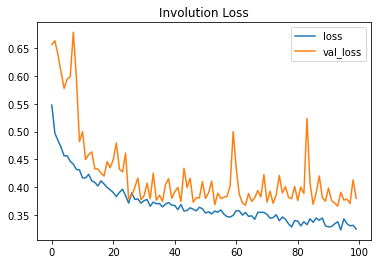

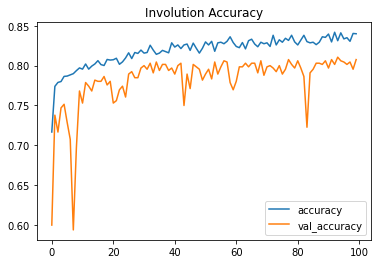

In [20]:
plt.title("Involution Loss")
plt.plot(inv_hist.history["loss"], label="loss")
plt.plot(inv_hist.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

plt.title("Involution Accuracy")
plt.plot(inv_hist.history["accuracy"], label="accuracy")
plt.plot(inv_hist.history["val_accuracy"], label="val_accuracy")
plt.legend()
plt.show()